<a id='toc'></a>
# Table of contents

1. [Import](#imports)
1. [Constants](#constants)
1. [File structure](#file-structure)
1. [EDA](#eda)
1. [](#)
1. [](#)



<a id='imports'></a>
# Imports

[Back to TOC](#toc)

In [319]:
import os
import sys
import random
import math
from glob import glob
from typing import Tuple, Optional    
from tqdm import tqdm

import pandas as pd
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

import torchvision
import torch
import torch.nn as nn
from torch.optim import Adam, lr_scheduler 
import torch.nn.functional as F

# Ensure DETERMINISTIC behavior!
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# Warnings handling (especially annoying when plotting)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


# Setting the notebook name for wandb
os.environ['WANDB_NOTEBOOK_NAME'] = 'mnist_WANDB_notebook'

<a id='constants'></a>
# Constants

[Back to TOC](#toc)

In [ ]:
# Constants
# When using the vim replate method, the "\" is used to escape special characters. So the command used would be :%s/\\/\//g  (g flag to replace the entire line).
ROOT_PATH:str = r'/mnt/d/GuidoCursosData/Python/datascience/datascience/Pytorch/cancer-dataset/Data Set'
FOLDER_PATH:str = ROOT_PATH + '/IDC_regular_ps50_idx5/'


# For plotting histograms 
BINS:int = 40

<a id='file-structure'></a>
# File structure

[Back to TOC](#toc)

In [125]:
# Each different folder represents a unique patient's ID, each one with 1 and 0 classes image patches.
print(f"Number of patients: {len(os.listdir(FOLDER_PATH))}")

# Patient ID's
all_ids = os.listdir(FOLDER_PATH)

Number of patients: 279


##### Have 279 different patients.
##### How many images, both counting 0's and 1's?


In [159]:
# List with ALL of the images files, 1's and 0's for ALL patients. Make sure to put the double *'s before the final .png, to include the subdirs inside each patient folder.
# Takes 15 sec
all_imgs_path = glob(FOLDER_PATH +'**/*.png', recursive=True)

# Splitting by the / delimitir, and extracting the class name from the path 
positive_imgs_path = [img_path for img_path in all_imgs_path if img_path.split('/')[-2] == '1']
negative_imgs_path = [img_path for img_path in all_imgs_path if img_path.split('/')[-2] == '0']

print(f"N° of total POSTIVE images: {len(positive_imgs_path)}")
print(f"N° of total NEGATIVE images: {len(negative_imgs_path)}")
print(f"N° of total images: {len(all_imgs_path)}")


N° of total POSTIVE images: 78786
N° of total NEGATIVE images: 198738
N° of total images: 277524


In [213]:
def plot_patches_of_class(cancer_class:int, 
                         grid_rows:int = 5,
                         grid_cols:int = 10, 
                         figsize:Tuple[int,int] = (20,10)) -> None:
    """ Function to plot patches of the chosen cancer type in a grid fashion
    """
   
    img_path_list = positive_imgs_path if cancer_class == 1 else negative_imgs_path

    # Creating the grid and its subplots
    fig, ax = plt.subplots(grid_rows, grid_cols, figsize=figsize)
    plt.suptitle(f"Class: '{str(cancer_class)}' random img patches", fontsize=20)

    for row in range(grid_rows):
        for col in range(grid_cols):
            # The 2 and 20 are in order to get imgs from different patients, non consecutive ones
            current_img_path = img_path_list[2*row+50*col]
            current_img_read = plt.imread(current_img_path)
            ax[row, col].imshow(current_img_read)

            # Deleting ticks
            # ax[row, col].set_yticks([])
            # ax[row, col].set_xticks([])

            # This deletes ALL ticks, maybe thats why the title doesnt show?
            plt.setp(ax[row,col].get_xticklabels(), visible=False)
            plt.setp(ax[row,col].get_yticklabels(), visible=False)

            # Set title to patient id and class, extracted from path of the current img
            current_patient_id = current_img_path.split('/')[-3]
            current_patient_class = current_img_path.split('/')[-2]

            # Disabling the gridlines inside each img
            ax[row, col].grid(visible=False)

            # TODO: find out why does neither one (nor suptitle, nor subtitles) work?
            #ax[row, col].set(title=f"{current_patient_id}-{current_patient_class}", ylabel='$C_y$')
            ax[row, col].tick_params(axis='both', which='both', length=0)

#### Plotting POSITIVE patches

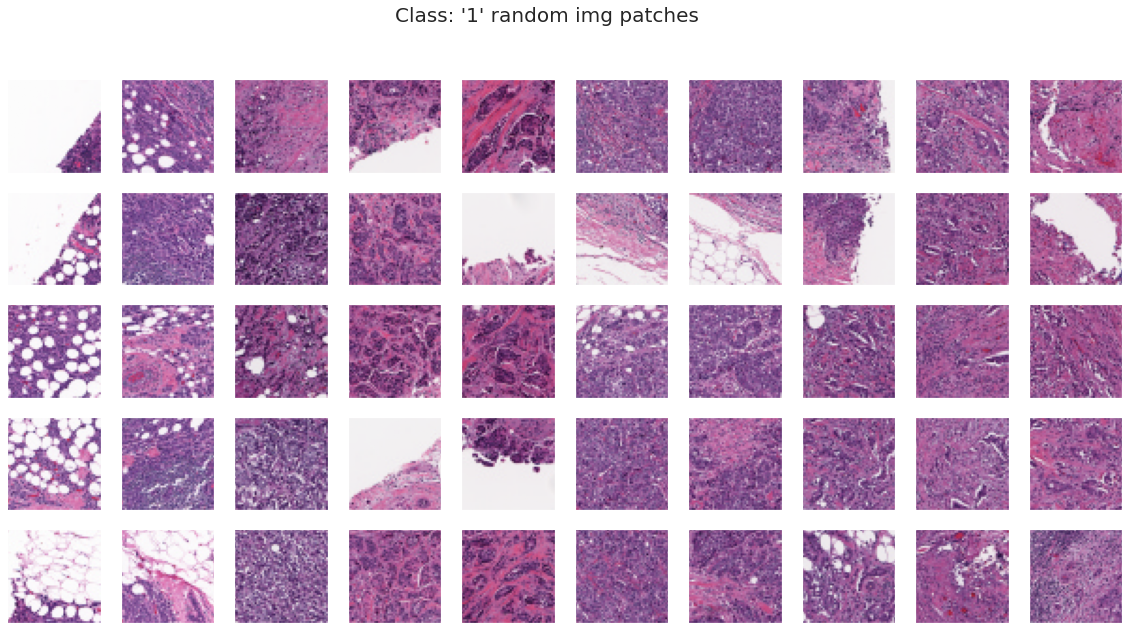

In [215]:
# 50 
plot_patches_of_class(1)

#### Plotting NEGATIVE patches

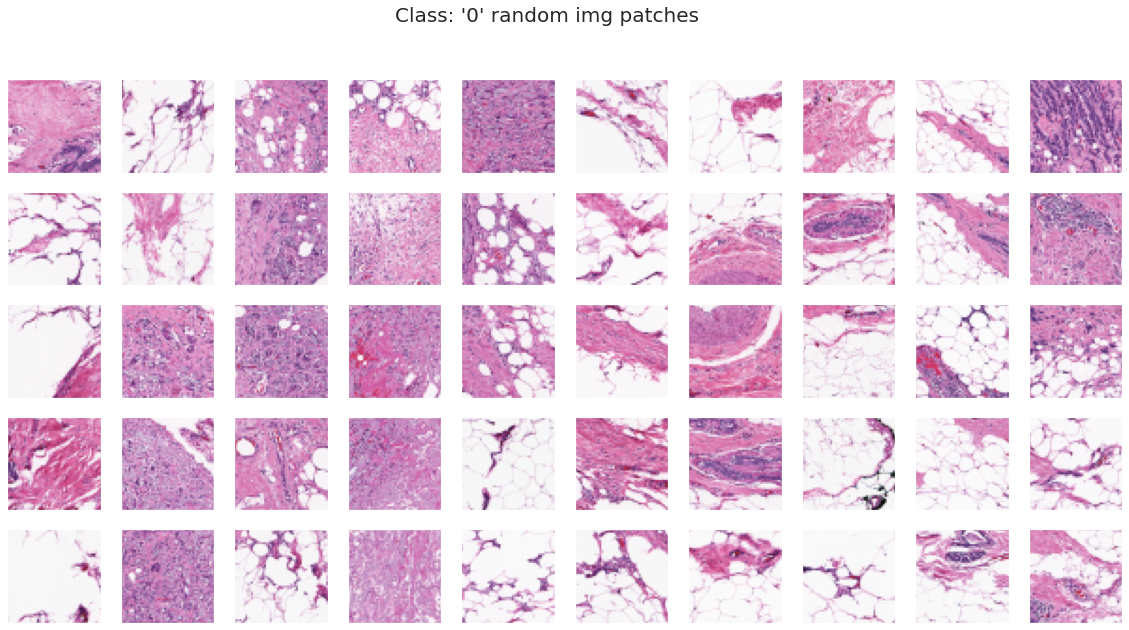

In [214]:
# 50 negative patches
plot_patches_of_class(0)

<a id='eda'></a>
# EDA

Creating a DF, in order to draw conclussions based on by-patient-aggregated metrics 

Each entry of the DF corresponds to each img path, consisting in:

1. Patient ID
2. Path to the corresponding img path
2. X coordinate
2. Y coordinate
2. Cancer type

[Back to TOC](#toc)

In [268]:
# Using an example to see where to extract the info I want for the DF
# For the patient ID
print(f"Patient ID: {all_imgs_path[1].split('/')[-3]}")

# For the class type
print(f"Class type: {all_imgs_path[1].split('/')[-2]}")

# For the x coord
print(f"X coord: {all_imgs_path[1].split('/')[-1].split('_')[-3][1:]}")

# For the y coord
print(f"Y coord: {all_imgs_path[1].split('/')[-1].split('_')[-2][1:]}")

# Rechecking the whole path
print(f"Full path: '{all_imgs_path[1]}'")

Patient ID: 10253
Class type: 0
X coord: 1001
Y coord: 1051
Full path: '/mnt/d/GuidoCursosData/Python/datascience/datascience/Pytorch/cancer-dataset/Data Set/IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001_y1051_class0.png'


In [265]:
# Setting up the lists that are going to make the DF with the whole info
ordered_x_coords = [curr_path.split('/')[-1].split('_')[-3][1:] for curr_path in all_imgs_path]
ordered_y_coords = [curr_path.split('/')[-1].split('_')[-2][1:] for curr_path in all_imgs_path]
ordered_classes = [curr_path.split('/')[-2] for curr_path in all_imgs_path]
ordered_patients = [curr_path.split('/')[-3] for curr_path in all_imgs_path]

In [272]:
# Checking that the lengths are correct
print(len(ordered_patients))
print(len(ordered_classes))
print(len(ordered_x_coords))
print(len(ordered_y_coords))

# Taking a look at the last ranges to see if they match
print(f"Patients ID: {ordered_patients[-5:]}")
print(f"Classes: {ordered_classes[-5:]}")
print(f"X coords: {ordered_x_coords[-5:]}")
print(f"Y coords: {ordered_y_coords[-5:]}")
print(f"Paths: {all_imgs_path[-5:]}")

277524
277524
277524
277524
Patients ID: ['9383', '9383', '9383', '9383', '9383']
Classes: ['1', '1', '1', '1', '1']
X coords: ['2051', '2051', '2101', '2101', '2101']
Y coords: ['901', '951', '1001', '901', '951']
Paths: ['/mnt/d/GuidoCursosData/Python/datascience/datascience/Pytorch/cancer-dataset/Data Set/IDC_regular_ps50_idx5/9383/1/9383_idx5_x2051_y901_class1.png', '/mnt/d/GuidoCursosData/Python/datascience/datascience/Pytorch/cancer-dataset/Data Set/IDC_regular_ps50_idx5/9383/1/9383_idx5_x2051_y951_class1.png', '/mnt/d/GuidoCursosData/Python/datascience/datascience/Pytorch/cancer-dataset/Data Set/IDC_regular_ps50_idx5/9383/1/9383_idx5_x2101_y1001_class1.png', '/mnt/d/GuidoCursosData/Python/datascience/datascience/Pytorch/cancer-dataset/Data Set/IDC_regular_ps50_idx5/9383/1/9383_idx5_x2101_y901_class1.png', '/mnt/d/GuidoCursosData/Python/datascience/datascience/Pytorch/cancer-dataset/Data Set/IDC_regular_ps50_idx5/9383/1/9383_idx5_x2101_y951_class1.png']


In [284]:
# Now that I have everything in order, I can create the DF based on the lists

raw_data = pd.DataFrame({
    'id':ordered_patients,
    'path':all_imgs_path,
    'x_coord':ordered_x_coords,
    'y_coord':ordered_y_coords,
    'target':ordered_classes
})

# Forcing dtypes
raw_data['id'] = raw_data['id'].astype('category')
raw_data['path'] = raw_data['path'].astype('str')  # TODO: why does it stays as object dtype and not str?
raw_data['x_coord'] = raw_data['x_coord'].astype('int32')
raw_data['y_coord'] = raw_data['y_coord'].astype('int32')
raw_data['target'] = raw_data['target'].astype('int32')

# Rechecking length and dtypes
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277524 entries, 0 to 277523
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype   
---  ------   --------------   -----   
 0   id       277524 non-null  category
 1   path     277524 non-null  object  
 2   x_coord  277524 non-null  int32   
 3   y_coord  277524 non-null  int32   
 4   target   277524 non-null  int32   
dtypes: category(1), int32(3), object(1)
memory usage: 5.8+ MB


In [285]:
raw_data.head(10)

,id,path,x_coord,y_coord,target
0,10253,/mnt/d/GuidoCursosData/Python/datascience/data...,1001,1001,0
1,10253,/mnt/d/GuidoCursosData/Python/datascience/data...,1001,1051,0
2,10253,/mnt/d/GuidoCursosData/Python/datascience/data...,1001,1101,0
3,10253,/mnt/d/GuidoCursosData/Python/datascience/data...,1001,1151,0
4,10253,/mnt/d/GuidoCursosData/Python/datascience/data...,1001,1201,0
5,10253,/mnt/d/GuidoCursosData/Python/datascience/data...,1001,1251,0
6,10253,/mnt/d/GuidoCursosData/Python/datascience/data...,1001,1301,0
7,10253,/mnt/d/GuidoCursosData/Python/datascience/data...,1001,1351,0
8,10253,/mnt/d/GuidoCursosData/Python/datascience/data...,1001,1501,0
9,10253,/mnt/d/GuidoCursosData/Python/datascience/data...,1001,1551,0


Now, can extract meaningful insights, since we can aggregate the data

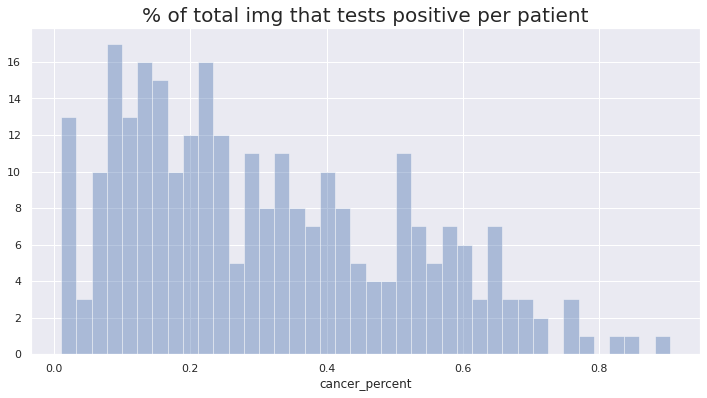

In [338]:
# Gonna aggregate by ID

#pd.DataFrame(raw_data.groupby('id')['target'].agg('mean').sort_values(ascending=False)).reset_index()
cancer_percent = pd.DataFrame(raw_data.groupby('id')['target'].agg('mean').reset_index()).rename(columns={'target':'cancer_percent'})

def plot_histogram(dataframe: pd.DataFrame,
                   col_to_agg:str, 
                   title:str, 
                   bins:int = BINS, 
                   figsize:Tuple[int,int] = (12,6),
                   title_fontsize:int = 20) -> None:
    """ Plotting ID-aggregated histograms, only based on 1 aggregation
    """
    plt.figure(figsize=figsize)
    sns.distplot(dataframe[col_to_agg], kde=False, bins=bins)
    plt.title(title, fontsize=title_fontsize)

# Plotting cancer % per patient
plot_histogram(dataframe=cancer_percent,
               col_to_agg='cancer_percent', 
               title='% of total img that tests positive per patient')

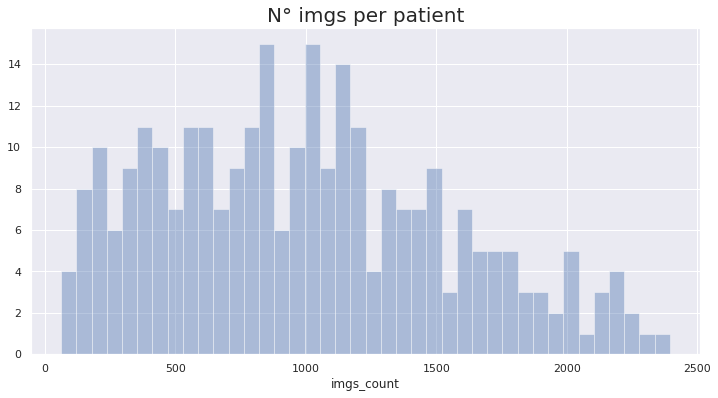

In [339]:
# Checking the n° of imgs corresponding to each patient
imgs_per_patient = pd.DataFrame(raw_data.groupby('id').agg(imgs_count=('id','count'))).reset_index()

# Plotting the n° imgs
plot_histogram(dataframe=imgs_per_patient,
               col_to_agg='imgs_count', 
               title='N° imgs per patient')

In [340]:
# TODO: this is where I left off, what to do next? Maybe join the 2 graphs into one, think about more aggregations? Maybe a particular zone that's generally more affected?
# TODO: maybe try to graph the entire pictures for a couple of ID's to see how they look like?